In [1]:
#basics
import pandas as pd 
import numpy as np
from collections import defaultdict, Counter

#misc
import gc
import time
import warnings

#viz
import matplotlib.pyplot as plt
import seaborn as sns

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#settings
start_time=time.time()
warnings.filterwarnings("ignore")


%matplotlib inline

In [2]:
train_df = pd.read_csv('train_df')
test_df = pd.read_csv('test_df')

In [3]:
list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [5]:
# Fill null comment with no commment
train_df['comment_text'] = train_df["comment_text"].fillna("no commment").tolist()
test_df['comment_text'] = test_df["comment_text"].fillna("no commment").tolist()

In [6]:
X_train = train_df['comment_text']
y_train = train_df[list_classes]

In [7]:
X_test = test_df['comment_text']
y_test = test_df[list_classes]

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(177351,)
(177351, 6)
(15952,)
(15952, 6)


In [9]:
X_train.head()

0                                      ged like penis 
1     illness nothing time era mental illnesses rea...
2                    do not understand fair use exist 
3     please vandalize page edit cause world war ii...
4    bryan holt worst ride operator knott s attenti...
Name: comment_text, dtype: object

In [10]:
y_train.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,1,0,1,0
1,0,0,0,0,1,1
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,1,0,0,0,0,0


### Unigram

In [11]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(min_df=10,  max_features=20000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# fit and transform on it the training features
tfidf.fit(X_train)
X_train_word_features = tfidf.transform(X_train)

#transform the test features to sparse matrix
test_features = tfidf.transform(X_test)

In [12]:
def show_confusion_matrix(cm_pred):
    fig = plt.figure(figsize = (6,4))
    sns.set(font_scale=0.8)
    title = class_name
    plt.title(title, fontsize = 15)
    sns.heatmap(cm_pred, cmap="Reds", square=True, fmt='.0f', cbar=False, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
losses = []
auc = []

CV Log_loss score for class toxic is -0.10230005679550225
CV Accuracy score for class toxic is 0.9676799197861232
CV ROC_AUC score 0.959414850503669

[[14154   270]
 [  425  1103]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     14424
           1       0.80      0.72      0.76      1528

    accuracy                           0.96     15952
   macro avg       0.89      0.85      0.87     15952
weighted avg       0.95      0.96      0.96     15952

None
CV Log_loss score for class severe_toxic is -0.03515458703205105
CV Accuracy score for class severe_toxic is 0.9869467864316419
CV ROC_AUC score 0.9654152301504236

[[15720    84]
 [   90    58]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15804
           1       0.41      0.39      0.40       148

    accuracy                           0.99     15952
   macro avg       0.70      0.69      0.70     15952
weighted avg       

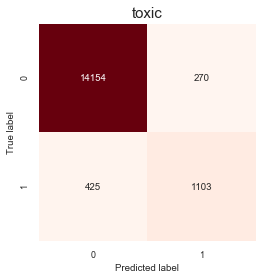

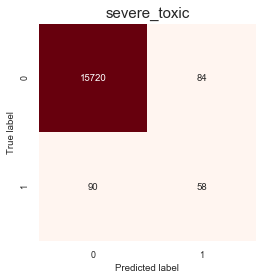

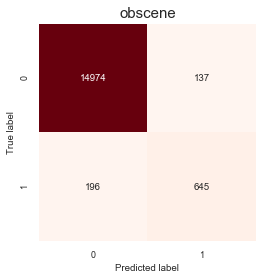

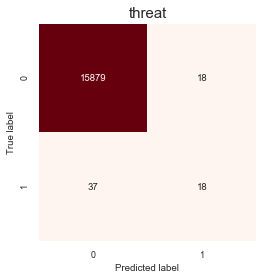

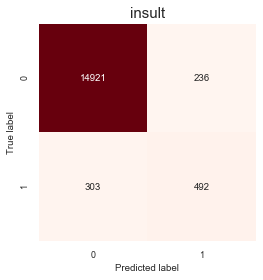

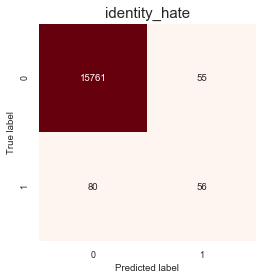

In [14]:
for class_name in list_classes:
    #call the labels one column at a time so we can run the classifier on them
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    classifier = LogisticRegression(solver='sag', C=10)
    
    
    cv_loss = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='neg_log_loss'))
    losses.append(cv_loss)
    print(f'CV Log_loss score for class {class_name} is {cv_loss}')
    
    #get model accuracy
    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='accuracy'))
    print(f'CV Accuracy score for class {class_name} is {cv_score}')
    
    classifier.fit(X_train_word_features, train_target)
    y_pred = classifier.predict(test_features)
    y_pred_prob = classifier.predict_proba(test_features)[:, 1]
    auc_score = roc_auc_score(test_target, y_pred_prob)
    auc.append(auc_score)
    print("CV ROC_AUC score {}\n".format(auc_score))
    
    print(confusion_matrix(test_target, y_pred))
    print(classification_report(test_target, y_pred))
    print(show_confusion_matrix(confusion_matrix(test_target, y_pred)))

print(f'Total average CV Log_loss score is {np.mean(losses)}')
print(f'Total average CV ROC_AUC score is {np.mean(auc)}')

### Bigram

In [15]:
bi_tfidf = TfidfVectorizer(min_df=10,  max_features=20000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')


# fit and transform on it the training features
bi_tfidf.fit(X_train)
bi_X_train_word_features = bi_tfidf.transform(X_train)

#transform the test features to sparse matrix
bi_test_features = bi_tfidf.transform(X_test)

In [16]:
bi_losses = []
bi_auc = []

CV Log_loss score for class toxic is -0.09796758206441471
CV Accuracy score for class toxic is 0.9696872380020617
CV ROC_AUC score 0.9621475569368099

[[14177   247]
 [  420  1108]]
None
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     14424
           1       0.82      0.73      0.77      1528

    accuracy                           0.96     15952
   macro avg       0.89      0.85      0.87     15952
weighted avg       0.96      0.96      0.96     15952

CV Log_loss score for class severe_toxic is -0.031128598487075675
CV Accuracy score for class severe_toxic is 0.9879955540025602
CV ROC_AUC score 0.967907970612982

[[15728    76]
 [   95    53]]
None
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15804
           1       0.41      0.36      0.38       148

    accuracy                           0.99     15952
   macro avg       0.70      0.68      0.69     15952
weighted avg 

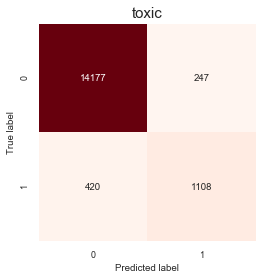

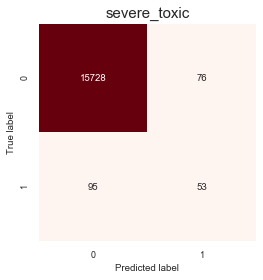

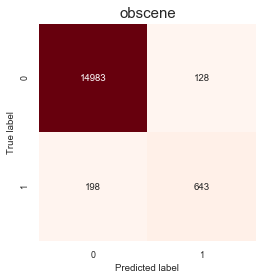

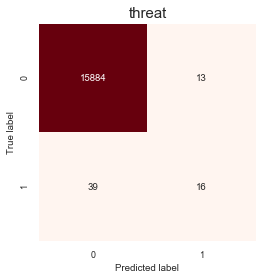

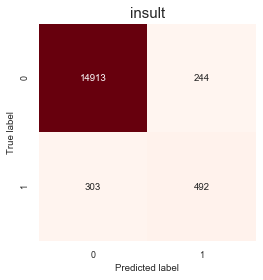

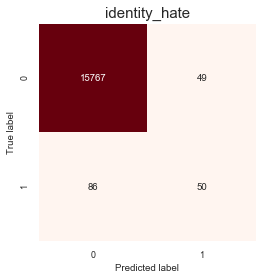

In [17]:
for class_name in list_classes:
    #call the labels one column at a time so we can run the classifier on them
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    classifier = LogisticRegression(solver='sag', C=10)

    cv_loss = np.mean(cross_val_score(classifier, bi_X_train_word_features, train_target, cv=5, scoring='neg_log_loss'))
    bi_losses.append(cv_loss)
    print(f'CV Log_loss score for class {class_name} is {cv_loss}')

    cv_score = np.mean(cross_val_score(classifier, bi_X_train_word_features, train_target, cv=5, scoring='accuracy'))
    print(f'CV Accuracy score for class {class_name} is {cv_score}')
    
    classifier.fit(bi_X_train_word_features, train_target)
    y_pred = classifier.predict(bi_test_features)
    y_pred_prob = classifier.predict_proba(bi_test_features)[:, 1]
    auc_score = roc_auc_score(test_target, y_pred_prob)
    bi_auc.append(auc_score)
    print(f"CV ROC_AUC score {auc_score}\n")
    
    print(confusion_matrix(test_target, y_pred))
    print(show_confusion_matrix(confusion_matrix(test_target, y_pred)))
    print(classification_report(test_target, y_pred))

print(f'Total average CV Log_loss score is {np.mean(bi_losses)}')
print(f'Total average CV ROC_AUC score is {np.mean(bi_auc)}')

##### Results for Unigram and Bigram are close.